In [2]:
# %pip install healpy
# %pip install astropy
# %pip install tqdm
import healpy as hp
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from tqdm import tqdm

### Get Z-Bins

In [3]:
z_bins = np.linspace(0,1,41)
z_bins = z_bins[1:]

In [4]:
z_bins

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975, 1.   ])

### Get Galaxy Data

In [5]:
# Read in 22.5 million data elements
data = pd.read_csv('GLADE+_2048.csv')
# gives only galaxies in our redshift bin
data = data.loc[(data.Z > 0) & (data.Z < np.max(z_bins))]

In [6]:
# I use parallel arrays to get around using data.iloc[i] repeatedly
pixels = data.Pix
z = data.Z
z_bin = data.Z_bin
# I accidentally saved my bins as floats -- can't use an index
# will fix, but for now just casting
data.astype({'Z_bin': 'int32'}).dtypes

Unnamed: 0      int64
Pix             int64
Z             float64
Z_bin           int32
dtype: object

### Get D10 Dust Map

In [7]:
# set map resolution
nside = 2048

# read in dust model map
dust_map = hp.read_map('d10_2048_353_I.fits')

npixels = len(dust_map)
"""
# dust map smoothed to 1 degree
smooth_dust_map = hp.sphtfunc.smoothing(dust_map, fwhm=0.0174533, iter=1)
"""

'\n# dust map smoothed to 1 degree\nsmooth_dust_map = hp.sphtfunc.smoothing(dust_map, fwhm=0.0174533, iter=1)\n'

### Use Histograms to Create Galaxy Maps by Redshift Bin

In [8]:
n_zbins = len(z_bins)

# create a blank map for each z-bin
z_maps = []

bins = np.arange(npixels + 1)

for i in tqdm(range(n_zbins)):
    pix_for_zbin_i_gal = pixels[z_bin == i]
    N_galaxies_in_zbin_i_in_each_pixel, bin_edges = np.histogram(pix_for_zbin_i_gal, bins=bins)
    z_maps.append(N_galaxies_in_zbin_i_in_each_pixel)

100%|███████████████████████████████████████████| 40/40 [05:34<00:00,  8.37s/it]


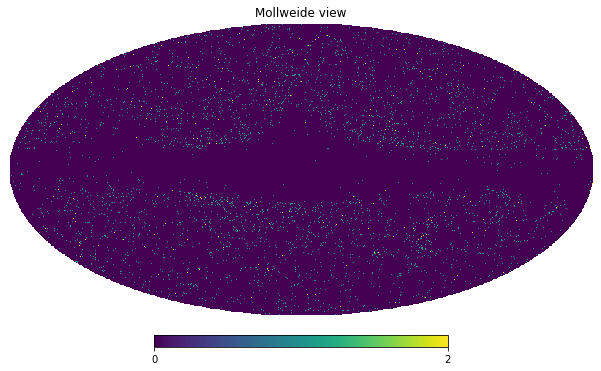

In [9]:
hp.mollview(z_maps[0],max=2)

### Create Lists to Hold Correlation Data and Create Sky Mask

In [10]:
corr_red = []

# this array will hold delta_r for each zbin
corr_bins = []
for i in range(40):
    corr_bins.append([])

mask_pix = np.arange(npixels)
mask_pix = [p for p in mask_pix if p < 15000000 or p > 35000000]

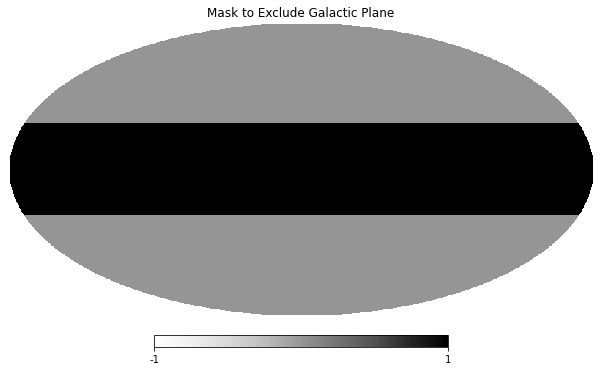

In [11]:
sample_mask = np.zeros(npixels)
sample_mask[15000000:35000000] = 1
hp.mollview(sample_mask,title='Mask to Exclude Galactic Plane',cmap='Greys',min=-1)

### Use Mean of Neighboring Pixels to Get Correlation Data

In [12]:
for p in tqdm(mask_pix):
    vec = vec = hp.pix2vec(nside=nside,ipix=p)
    pix_disc = hp.query_disc(nside=2048,vec=vec,radius=np.radians(0.0174533))
    corr_red.append(np.mean(dust_map[pix_disc]))
    for i in range(n_zbins):
        corr_bins[i].append(np.mean(z_maps[i][pix_disc]))

100%|███████████████████████████| 30331647/30331647 [2:40:12<00:00, 3155.39it/s]


### Cross-Correlate Galaxy Data with Dust Map Data

In [17]:
# store cross-correlation data
corr_data = np.zeros(len(corr_bins))

for i in tqdm(range(len(corr_bins))):
    corr_data[i] = np.correlate(corr_bins[i],corr_red)

100%|█████████████████████████████████████████████████████████████████████████████████████| 40/40 [4:05:06<00:00, 367.66s/it]


In [16]:
print(len(corr_data))

40


### Plot Masked Data vs. Unmasked Data

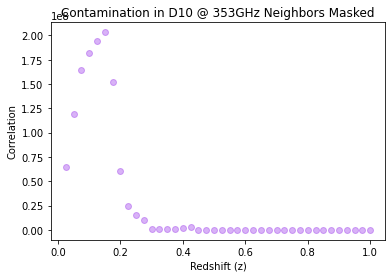

In [19]:
plt.scatter(z_bins,corr_data,color=(0.5,0.0,0.9,0.3))
plt.title('Contamination in D10 @ 353GHz Neighbors Masked')
plt.xlabel('Redshift (z)')
plt.ylabel('Correlation')
plt.show()

In [21]:
print(len(corr_bins[0]))

30331647
